In [1]:
%cd HW1
%matplotlib inline


[Errno 2] No such file or directory: 'HW1'
/home/zhaoyilin/AML/HW1


In [2]:
import numpy as np
import tqdm
import copy
from matplotlib import pyplot as plt


from experts_advice import ExpertsAdvice
from config import cloud_config, spambase_config
from experts import TheDataset

KeyboardInterrupt: 

# Function

In [ ]:

def jupyter_main(config):
    experts_advice=ExpertsAdvice(config)
    dataset = TheDataset(config.data_path, is_train=True, num_features=config.experts.expert.in_features)
    distributions = []
    experts_losses = []
    learner_losses = []
    for i, sample in tqdm.tqdm(enumerate(dataset)):
        x, y = sample
        experts_loss = experts_advice.train(x, y)
        learner_predict = experts_advice.predict(x)
        if experts_advice.task_type == 'classification':
            # predictions for chances that sample is classified as 1,
            learner_predict = 1 / (1 + np.exp(-learner_predict)) # sigmoid
            learner_predict = learner_predict.clip(1e-5, 1 - 1e-5) # in case log goes to inf
            learner_loss = - (y * np.log(learner_predict) + (1 - y) * np.log(1-learner_predict)) # nll loss
        elif experts_advice.task_type == 'regression':
            learner_loss = (y - learner_predict) ** 2 # mse loss
        distributions.append(copy.deepcopy(experts_advice.distribution))
        experts_losses.append(experts_loss)
        learner_losses.append(learner_loss)

    # distribution change
    distributions = np.array(distributions)
    smoothing = 200
    for i_expert in range(cloud_config.num_experts):
        dist_over_iter = distributions[:, i_expert]
        smoothed_list = []
        for i in range(dist_over_iter.shape[0]):
            index_min, index_max = max(0, i-smoothing), min(dist_over_iter.shape[0], i+smoothing)
            smoothed = dist_over_iter[index_min: index_max]
            smoothed_list.append(np.mean(smoothed))
        plt.plot(smoothed_list, label=f'expert {i_expert} weights')

    plt.legend()
    plt.title('expert weights over iterations')
    plt.show()


    # eval loss
    experts_losses = np.array(experts_losses)
    for i_expert in range(cloud_config.num_experts):
        losses = experts_losses[:, i_expert]
        losses = np.cumsum(losses)
        plt.plot(losses, label=f'expert {i_expert} loss')

    learner_losses = np.cumsum(np.array(learner_losses))

    plt.plot(learner_losses, label=f'learner loss')
    plt.legend()
    plt.title('cumulative loss over iterations')
    plt.show()

    eval_dataset = TheDataset(config.data_path, is_train=False, num_features=config.experts.expert.in_features)
    total, cost = len(eval_dataset), 0
    for sample in tqdm.tqdm(eval_dataset):
        x, y = sample
        pred_y = experts_advice.predict(x)
        if config.task_type == 'classification': 
            pred_y = int(pred_y > 0.5)
            if y != pred_y:
                cost += 1
        elif config.task_type == 'regression':
            cost += (pred_y - y) ** 2
        else:
            raise NotImplementedError()
        
    print(f'after iterating same training data--experts advice error on same eval data: {cost/total:.4f}')


# Spambase: Classification
- static

3681it [00:19, 192.40it/s]


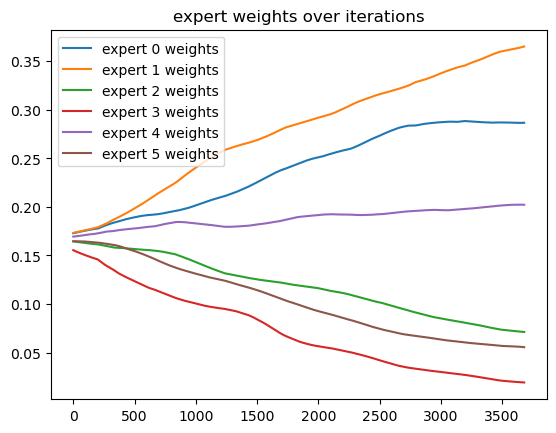

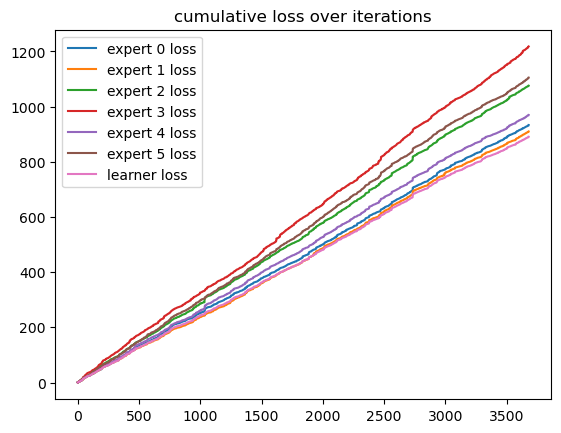

100%|██████████| 920/920 [00:02<00:00, 398.28it/s]

after iterating same training data--experts advice error on same eval data: 0.0935


In [ ]:
jupyter_main(spambase_config)


# Cloud: Regression
- fixshare alpha 0.2, 0.5, 0.8

1638it [00:08, 191.46it/s]


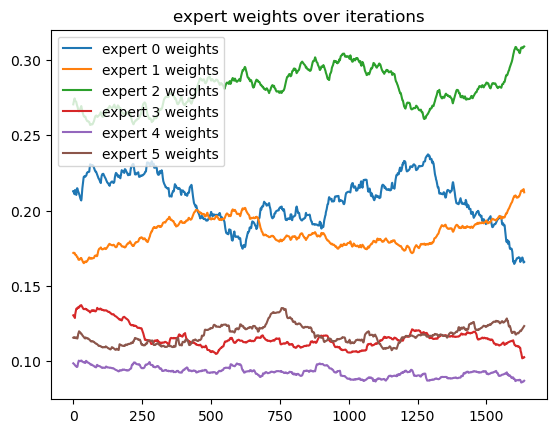

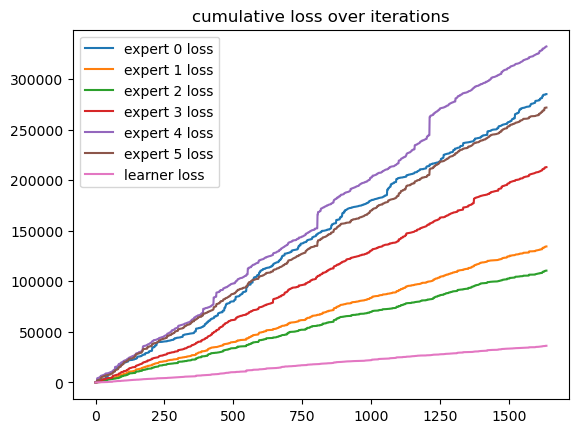

100%|██████████| 410/410 [00:01<00:00, 338.49it/s]

after iterating same training data--experts advice error on same eval data: 73.6498


In [ ]:
jupyter_main(cloud_config)


{'type': 'fixshare', 'alpha': 0.5, 'lr': 0.02}


1638it [00:08, 195.65it/s]


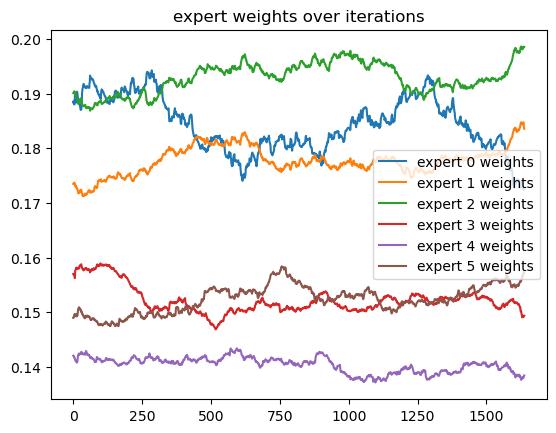

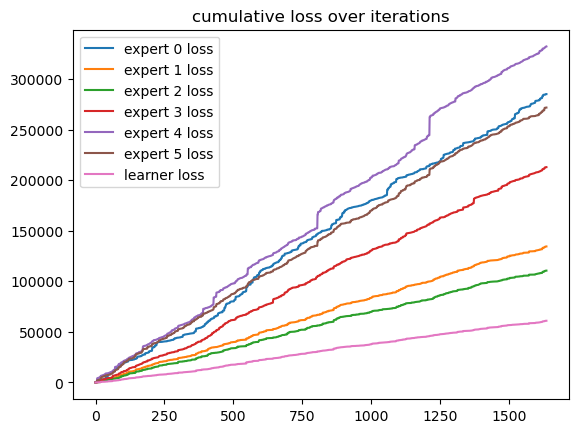

100%|██████████| 410/410 [00:01<00:00, 365.57it/s]

after iterating same training data--experts advice error on same eval data: 68.8556


In [ ]:
# alpha = 0.5
cloud_config.experts_advice.alpha=0.5
print(cloud_config.experts_advice)
jupyter_main(cloud_config)


{'type': 'fixshare', 'alpha': 0.8, 'lr': 0.02}


1638it [00:08, 193.49it/s]


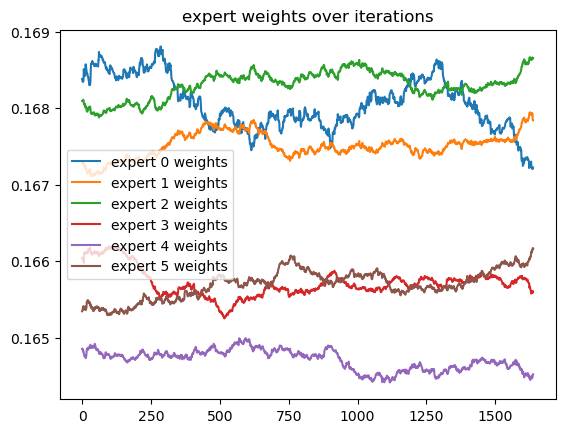

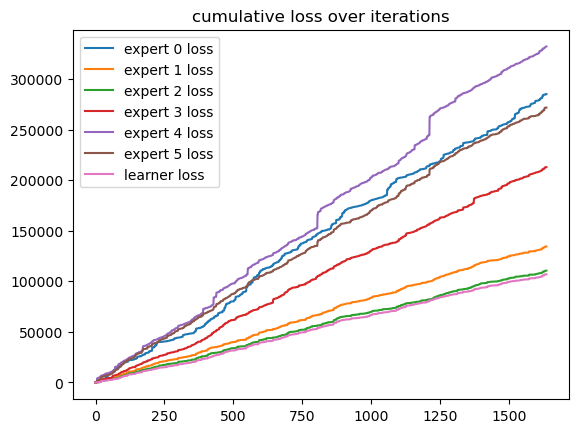

100%|██████████| 410/410 [00:01<00:00, 392.52it/s]

after iterating same training data--experts advice error on same eval data: 72.8845


In [ ]:
# alpha = 0.8
# alpha = 0.5
cloud_config.experts_advice.alpha=0.8
print(cloud_config.experts_advice)
jupyter_main(cloud_config)
